**NOTE** computing overlap based on string matches in the responses showed that there are a number of exact duplicates in the training data. This means that certain splits contain more duplicate responses than others and the size/amount of overlap differs quite a bit (up to 8K items).

If we use the input reviews, or rrgen_ids, the training sets are approximately the same size and overlap is around 50% for most training sets.

In [1]:
from pathlib import Path
import numpy as np
from collections import Counter
import pprint
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_path = '../hotel'

train_sets = {
    'filt_freq_distro_0.0_0.883': 'lex. freq.',
#     'filt_response_tfidf_1.37_1.8': 'tgt TF-IDF',
    'filt_generic_sent_avg_0.0_0.7': 'sent. avg.',
    'filt_tgt_ppl_23.5_50': 'LM PPL',
#     'filt_rev_resp_tfidf_0.118_0.6': 'src-tgt TF-IDF',
#     'filt_rev_resp_sts_0.51_0.8': 'src-tgt STS',
    }

In [3]:
def collect_counted_lines(file):
    with open(file, 'r', encoding='utf8') as f:
        return Counter([line.strip() for line in f])

data_responses = {}
for k, v in train_sets.items():
    id_file = Path(data_path) / k / 'train.response'
    data_responses[v] = collect_counted_lines(id_file)
    
for i, ik in enumerate(data_responses.keys()):
    print(ik)
    pprint.pprint(data_responses[ik].most_common(3))
    print()

lex. freq.
[('Hello, Thank you for taking the time to review Mantra Lorne. Your feedback '
  'has been correlated and will assist us in targeting areas for improvement, '
  'so thank you for sharing your experience. Cheers Abraham',
  231),
 ('Thank you for taking the time to complete our guest survey about your '
  'recent experience at The Ambassador Hotel & Conference Centre. Your '
  'feedback is critical to our continued improvement and success! We hope you '
  'will come back and stay with us again soon. Please contact me personally to '
  'arrange your next visit so I can ensure your next stay is nothing less than '
  'exceptional. Warm Regards, Ashley MacGillivray | Guest Services Manager '
  'ashley.macgillivray@ambassadorhotel.com Phone: 613-548-3605 | '
  '1-800-267-7880',
  70),
 ('Dear Valued Guest, We thank you for choosing the LaQuinta Inn & Suites '
  'Indianapolis Downtown, Your feedback is crucial to us as we strive to excel '
  'in every aspect of your stay. We are t

In [4]:
def collect_ids(file):
    with open(file, 'r', encoding='utf8') as f:
        return set([int(line.strip()) for line in f])

data = {}
for k, v in train_sets.items():
    id_file = Path(data_path) / k / 'train.rrgen_id'
    data[v] = collect_ids(id_file)
    
# for k in data.keys():
#     print(len(data[k]))

In [5]:
m = np.zeros((len(data), len(data)), dtype=np.int32)
m_perc = np.zeros((len(data), len(data)), dtype=np.int32)

for i, ik in enumerate(data.keys()):
    for j, jk in enumerate(data.keys()):
#         print(ik, jk)
        intersect = data[ik].intersection(data[jk])
        m[i][j] = len(intersect)
        m_perc[i][j] = round(len(intersect) / len(data[ik]) * 100)
        
# print(m)
# print(m_perc)

In [6]:
# create masks for overlaying the matrices
# top-right contains percentage overlap
# bottom-left contains raw counts

mask_u = np.zeros_like(m)
mask_u[np.triu_indices_from(m, 1)] = True
mask_l = np.zeros_like(m)
mask_l[np.tril_indices_from(m, 0)] = True

# print(mask_u)
# print(mask_l)

m = m * mask_l
m_perc = m_perc * mask_u
m = m+m_perc
print(m)


[[183885     65     57]
 [119992 182741     57]
 [105088 103992 181924]]


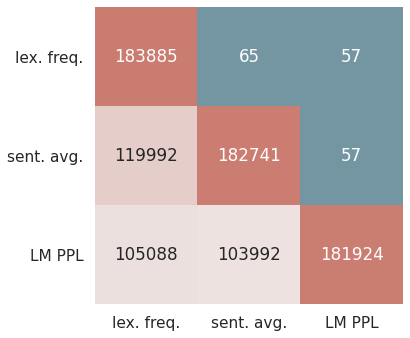

In [15]:
# create heatmap plot
cm = sns.diverging_palette(220, 20, s=40, l=60, as_cmap=True)
with plt.style.context('seaborn-paper'):
    sns.set(font_scale=1.4)
    f, ax = plt.subplots(figsize=(6, 5))
#     print(axes)
    sns.heatmap(m, annot=True, fmt="d", cmap=cm, xticklabels=list(data.keys()), yticklabels=list(data.keys()), ax=ax, cbar=False)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig('./plots/train_set_overlap_3.pdf', dpi=300)
    plt.savefig('./plots/train_set_overlap_3.png', dpi=300)

In [9]:
105088 / 182741

0.5750652562916915

In [10]:
103992 / 181924

0.5716233152305358

In [11]:
119992 / 183885

0.65253827120211

In [13]:
105088 / 183885

0.5714876145416973